<a href="https://colab.research.google.com/github/Yousef-Taheri/Algorithmic-Trading/blob/master/EM_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#Simulation

In [0]:
######### simulation function
def simulFunc(params,n):
  z=np.random.choice(len(params['lmbd']))
  price=np.random.binomial(1,p=1-params['zprob'][z])*np.random.normal(scale=params['sigma'][z])
  tt=np.floor( np.random.exponential(scale=1/params['lmbd'][z]))
  latentZ=[z]
  log_mid_price=[price]
  time_between_trades=[tt]
  for i in range(n-1):
    z=np.random.choice(len(params['lmbd']),p=params['transition'][z])
    price=np.random.binomial(1,p=1-params['zprob'][z])*np.random.normal(scale=params['sigma'][z])
    tt=np.floor( np.random.exponential(scale=1/params['lmbd'][z])) #floor because the real data is censored
    latentZ.append(z)
    log_mid_price.append(price)
    time_between_trades.append(tt)
  return np.array(latentZ), np.array(log_mid_price), np.array(time_between_trades)


## 2 regime simulation- PCP

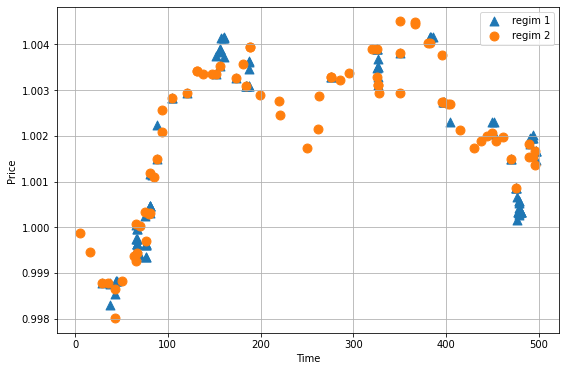

In [3]:
params={'transition':[[.8,.2],[.43,.57]],
        'lmbd':[1.37,0.14],
        'zprob':[0.56,0.14],
        'sigma':[.00029,.00063]}
latentZ, log_mid_price, time_between_trades=simulFunc(params,200)
price_process=1*np.exp(np.cumsum(log_mid_price))
time_process=np.cumsum(time_between_trades)

#plotting the sample price path
plt.figure(figsize=(9,6))
plt.scatter(time_process[latentZ==0],price_process[latentZ==0],s=80,marker='^')

plt.scatter(time_process[latentZ==1],price_process[latentZ==1],s=80,marker='o')
plt.xlabel("Time")
plt.grid()
plt.ylabel("Price");
plt.legend(['regim 1','regim 2']);



##4 regimes simulation- AMZN

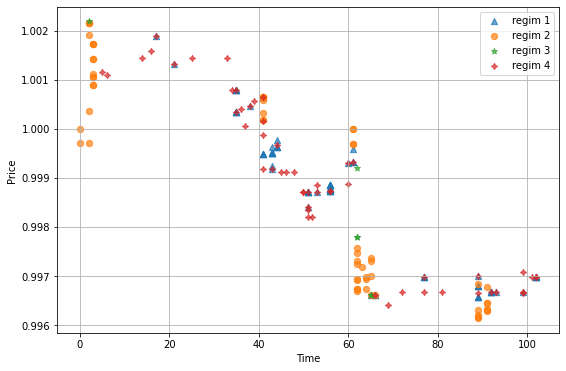

In [4]:

params={'transition':np.array([[79.88,3.05,0.04,17.03],
                      [1.14,94.48,1.18,3.20],
                      [3.05,18.64,75.95,2.36],
                      [43.08,0.60,0.08,56.24]])/100,
        'lmbd':[2.614,2.101,1.203,0.487],
        'zprob':np.array([85.57,46.57,26.34,29.06])/100,
        'sigma':np.array([1.810,2.931,11.480,2.496])*1e-4}
latentZ, log_mid_price, time_between_trades=simulFunc(params,200)
price_process=1*np.exp(np.cumsum(log_mid_price))
time_process=np.cumsum(time_between_trades)

#plotting
marker_size=40
plt.figure(figsize=(9,6))
plt.scatter(time_process[latentZ==0],price_process[latentZ==0],alpha=.7,s=marker_size,marker='^')
plt.scatter(time_process[latentZ==1],price_process[latentZ==1],alpha=.7,s=marker_size,marker='o')
plt.scatter(time_process[latentZ==2],price_process[latentZ==2],alpha=.7,s=marker_size,marker='*')
plt.scatter(time_process[latentZ==3],price_process[latentZ==3],alpha=.7,s=marker_size,marker=(4,1))
plt.xlabel("Time")
plt.grid()
plt.ylabel("Price");
plt.legend(['regim 1','regim 2','regim 3','regim 4']);



#Estimation

##mixture density function

In [0]:
theta={'lmbd':.14,'zprob':.14,'sigma':.00063}
def log_mixture_density(t,x,theta):
  lmbd=theta['lmbd']
  zprob=theta['zprob']
  sigma=np.float64(theta['sigma'])
  log_cencored_time=-lmbd*t+np.log((1-np.exp(-lmbd)))
  log_log_price_revision= np.log(zprob) if x==0  else np.log(1-zprob)+norm.logpdf(x,scale=sigma)
  return log_cencored_time+log_log_price_revision


In [0]:
def mixture_density(t,x,theta):
  lmbd=theta['lmbd']
  zprob=theta['zprob']
  sigma=np.float64(theta['sigma'])
  log_cencored_time=np.exp(-lmbd*t)*(1-np.exp(-lmbd))
  log_log_price_revision= zprob if x==0  else (1-zprob)*norm.pdf(x=x,loc=0,scale=sigma)
  return log_cencored_time*log_log_price_revision

##forward function

In [0]:
def alpha_forward(hmm_params,time,price):
  nb_states=len(hmm_params['lmbd'])
  theta=[{key: hmm_params[key][k] for key in ['lmbd','zprob','sigma']} for k in range(nb_states)]
  alpha_old=[ np.exp(p)*mixture_density(time[0],price[0],theta[i]) for i,p in enumerate(hmm_params['log_initProb'])]
  alpha_old=np.array(alpha_old,dtype=np.longfloat)
  alpha_old=alpha_old/np.sum(alpha_old)
  scles=[np.sum(alpha_old)] #initilizing scales
  alpha_list=[alpha_old]
  
  tr_mat=np.exp(hmm_params['log_transition'],dtype=np.longfloat)
  for t,x in zip(time[1:],price[1:]):
    ll=[]
    for i in range(nb_states):
      s=0
      for j in range(nb_states):
        s=s+alpha_old[j]*tr_mat[j][i]*mixture_density(t,x,theta[i])
      ll.append(s)
    cc=np.sum(ll)
    ll=ll/cc
    scles.append(cc)
    alpha_list.append(ll)
    alpha_old=ll.copy()
  return np.array(alpha_list),scles

##backward function

In [0]:
def beta_backward(hmm_params,scales,time,price):
  nb_states=len(hmm_params['lmbd'])
  nb_samples=len(time)
  theta=[{key: hmm_params[key][k] for key in ['lmbd','zprob','sigma']} for k in range(nb_states)]
  #print(log_mixture_density(time[0],price[0],theta[0]))
  beta_old=np.full(nb_states,1,dtype=np.longfloat)
  #beta_old=beta_old/scales[-1]
  beta_list=[beta_old]
  #print(alpha_old)
  tr_mat=np.exp(hmm_params['log_transition'],dtype=np.longfloat)
  for k in range(2,nb_samples+1):
    ll=[]
    for i in range(nb_states):
      s=0
      for j in range(nb_states):
        s=s+beta_old[j]*mixture_density(time[-k],price[-k],theta[j])*tr_mat[i][j]

      #a=beta_old[0]*mixture_density(time[-k],price[-k],theta[0])*tr_mat[i][0]
      #b=beta_old[1]*mixture_density(time[-k],price[-k],theta[1])*tr_mat[i][1]
      #aprox=a+b
      ll.append(s)
    #print("avant",ll)
    ll=np.array(ll)/scales[-k]
    #print("c",scales[-k])
    #print("apres",ll)
    beta_list.append(ll)
    beta_old=ll.copy()

  return np.array(beta_list)


## function for calculating $\xi_{t,ij}$

In [0]:
def log_epsilon(alphaMat,betaMat,time,price,hmm_params):
  log_tr_mat=hmm_params['log_transition']
  nb_states=len(hmm_params['lmbd'])
  nb_samples=len(time)
  theta=[{key: hmm_params[key][k] for key in ['lmbd','zprob','sigma']} for k in range(nb_states)]
  log_eps_list=[]
  for t in range(nb_samples-1):
    ilst=[]
    for i in range(nb_states):
      jlst=[]
      for j in range(nb_states):
        eps=(np.log(alphaMat[t][i])
          +log_tr_mat[i][j]
          +log_mixture_density(time[t+1],price[t+1],theta[j])
          +np.log(betaMat[-(t+1)][j]))#-log_seq_prob)
        jlst.append(eps)
      ilst.append(jlst)
    log_eps_list.append(ilst)
  return log_eps_list

In [0]:
def log_epsilon_numerator(alphaMat,betaMat,time,price,hmm_params):
  log_tr_mat=hmm_params['log_transition']
  nb_states=len(hmm_params['lmbd'])
  nb_samples=len(time)
  theta=[{key: hmm_params[key][k] for key in ['lmbd','zprob','sigma']} for k in range(nb_states)]
  log_eps_list=[]
  for t in range(nb_samples-1):
    ilst=[]
    for i in range(nb_states):
      jlst=[]
      for j in range(nb_states):
        eps=(np.log(alphaMat[t][i])
          +log_tr_mat[i][j]
          +log_mixture_density(time[t+1],price[t+1],theta[j])
          +np.log(betaMat[-(t+1)][j]))

        jlst.append(eps)
      
      ilst.append(jlst)
    log_eps_list.append(ilst)
  
  return log_eps_list


## log-liklihood function

In [0]:
def log_liklihood(hmm_params,time,price,pj,pjk):
  nb_states=len(hmm_params['lmbd'])
  nb_samples=len(time)
  theta=[{key: hmm_params[key][k] for key in ['lmbd','zprob','sigma']} for k in range(nb_states)]

  term1=0
  for t in range(nb_samples):
    for j in range(nb_states):
      term1=term1+log_mixture_density(time[t],price[t],theta[j])*np.exp(pj[t][j])
  
  log_tr_mat=hmm_params['log_transition']
  term2=0
  for t in range(nb_samples-1):
    for j in range(nb_states):
      for k in range(nb_states):
        term2=term2+log_tr_mat[j][k]*np.exp(pjk[t][j][k])
      
  log_pi=hmm_params['log_initProb']
  term3=0
  for j in range(nb_states):
    term3=term3+log_pi[j]*np.exp(pj[0][j])
  
  return term1+term2+term3


## EM algorithm

In [0]:
def EM(initParams,time,price,nb_iter,frq=100,verbose=False):
  time=np.array(time)
  price=np.array(price)
  hmm_params=initParams.copy()
  updated_params=initParams.copy()
  logLike_list=[]
  nb_states=len(hmm_params['lmbd'])
  nb_samples=len(time)
  mmm=[[0.2,.8],[0.8,0.2]]
  loglike_old=0
  for i in range(nb_iter):
    alpha_mat,scales=alpha_forward(hmm_params,time,price)
    beta_mat=beta_backward(hmm_params,scales,time,price)
    log_eps_numer=log_epsilon_numerator(alpha_mat,beta_mat,time,price,hmm_params)
    log_rtj=np.log(beta_mat[::-1]*alpha_mat) #[np.log(np.sum(np.exp(x),axis=1)) for x in log_eps_mat]
    loglike=log_liklihood(hmm_params,time,price,log_rtj,log_eps_numer)
    if np.abs(loglike_old-loglike)<1e-6:
      break
    loglike_old=loglike
    logLike_list.append(loglike)
    if verbose and i%frq==0:
      print('iteration: ',i)
      print('logliklihood: ',loglike)
      param_copy=updated_params.copy()
      param_copy['log_transition']=np.exp(param_copy['log_transition'])
      param_copy['log_initProb']=np.exp(param_copy['log_initProb'])
      print(param_copy)
    #parameter update
    for j in range(nb_states):
      updated_params['lmbd'][j]=-np.log(np.sum(np.exp(log_rtj[:,j])*time)/np.sum(np.exp(log_rtj[:,j])*(time+1)))
      updated_params['zprob'][j]= np.sum(np.exp(log_rtj[price==0,j]))/np.sum(np.exp(log_rtj[:,j]))
      updated_params['sigma'][j]=np.sqrt( np.sum(np.exp(log_rtj[price!=0,j])*(price[price!=0]**2))/np.sum(np.exp(log_rtj[price!=0,j])))
      for k in range(nb_states):
        epssjk=np.exp([t[j][k] for t in log_eps_numer])
        updated_params['log_transition'][j][k]=np.sum(epssjk)/np.sum(np.exp(log_rtj[0:nb_samples,j]))#np.sum(epssj)
      updated_params['log_transition'][j]=np.sqrt(updated_params['log_transition'][j])#np.min(updated_params['log_transition'][j])
      updated_params['log_transition'][j]=updated_params['log_transition'][j]/np.sum(updated_params['log_transition'][j])
      updated_params['log_transition'][j]=np.log(updated_params['log_transition'][j])
      updated_params['log_initProb'][j]=log_rtj[0,j]
    
    updated_params['log_initProb']=np.exp(updated_params['log_initProb']-np.mean(updated_params['log_initProb']))
    updated_params['log_initProb']=np.sqrt(updated_params['log_initProb'])
    updated_params['log_initProb']=updated_params['log_initProb']/np.sum(updated_params['log_initProb'])
    updated_params['log_initProb']=np.log(updated_params['log_initProb'])
    hmm_params=updated_params.copy()
  return logLike_list, hmm_params

    


## Runnig EM for 2 rgime market

In [0]:
np.random.seed(1234)
hmm_params1={'log_transition':np.log([[0.001,.999],[0.999,0.001]]),  
            'lmbd':[1.47,.13],
            'zprob':[0.6,0.1],
            'log_initProb':np.log([.5,.5]),
            'sigma':[0.00021,0.00061]}

params={'transition':[[.8,.2],[.43,.57]],
        'lmbd':[1.37,0.14],
        'zprob':[0.56,0.14],
        'sigma':[.00029,.00063]}


latentZ, log_mid_price, time_between_trades=simulFunc(params,2000)
loglike,params1=EM(hmm_params1,time_between_trades,log_mid_price,400,frq=1,verbose=True)

iteration:  0
logliklihood:  -125887.554940174731435
{'log_transition': array([[-6.90775528e+00, -1.00050033e-03],
       [-1.00050033e-03, -6.90775528e+00]]), 'lmbd': [1.47, 0.13], 'zprob': [0.6, 0.1], 'log_initProb': array([-0.69314718, -0.69314718]), 'sigma': [0.00021, 0.00061]}
iteration:  1
logliklihood:  -52050.69071925110265
{'log_transition': array([[-2.0411465 , -0.13912382],
       [-0.01531733, -4.18641924]]), 'lmbd': [0.33363126953225204154, 1.586204284520313183], 'zprob': [0.2242728382376670518, 0.63030447300604444905], 'log_initProb': array([-2.61954379, -0.07562491]), 'sigma': [0.00044498074603660183074, 0.00022158650282685113806]}
iteration:  2
logliklihood:  -64509.919956342174537
{'log_transition': array([[-1.54358941, -0.24030622],
       [-0.12546609, -2.13779701]]), 'lmbd': [0.50716744552304996325, 1.0520563957905908442], 'zprob': [0.5257954412609486309, 0.48090755252541825843], 'log_initProb': array([-0.02324732, -3.77316672]), 'sigma': [0.00044058112642656647665,

KeyboardInterrupt: ignored

##plotting logliklihood for 2 regime market

Text(0, 0.5, 'log liklihood')

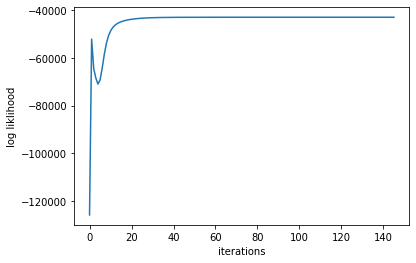

In [0]:
plt.plot(loglike)
plt.xlabel("iterations")
plt.ylabel("log liklihood")

## Running EM for 4 regime Market

In [17]:
np.random.seed(1532)
hmm_params1={'log_transition':np.log(np.array([[1.14,94.48,1.18,3.20],
                                              [79.88,3.05,0.04,17.03],
                                              [43.08,0.60,0.08,56.24],
                                              [3.05,18.64,75.95,2.36]
                                              ])/100),
        'lmbd':[2.614,2.101,1.203,0.487],
        'zprob':np.array([85.57,46.57,26.34,29.06])/100,
        'log_initProb':np.log([.25,.25,.25,.25]),
        'sigma':np.array([1.810,2.931,11.480,2.496])*1e-4}


params={'transition':np.array([[79.88,3.05,0.04,17.03],
                      [1.14,94.48,1.18,3.20],
                      [3.05,18.64,75.95,2.36],
                      [43.08,0.60,0.08,56.24]])/100,
        'lmbd':[2.614,2.101,1.203,0.487],
        'zprob':np.array([85.57,46.57,26.34,29.06])/100,
        'sigma':np.array([1.810,2.931,11.480,2.496])*1e-4}

latentZ, log_mid_price, time_between_trades=simulFunc(params,5000)
loglike,params1=EM(hmm_params1,time_between_trades,log_mid_price,10,frq=1,verbose=True)

iteration:  0
logliklihood:  -371068.33243730688605
{'log_transition': array([[1.140e-02, 9.448e-01, 1.180e-02, 3.200e-02],
       [7.988e-01, 3.050e-02, 4.000e-04, 1.703e-01],
       [4.308e-01, 6.000e-03, 8.000e-04, 5.624e-01],
       [3.050e-02, 1.864e-01, 7.595e-01, 2.360e-02]]), 'lmbd': [2.614, 2.101, 1.203, 0.487], 'zprob': array([0.8557, 0.4657, 0.2634, 0.2906]), 'log_initProb': array([0.25, 0.25, 0.25, 0.25]), 'sigma': array([0.000181 , 0.0002931, 0.001148 , 0.0002496])}
iteration:  1
logliklihood:  -427931.80418851015494
{'log_transition': array([[0.04119017, 0.82658728, 0.04851488, 0.08370767],
       [0.48252005, 0.20217155, 0.01339815, 0.30191024],
       [0.17446354, 0.04124244, 0.00992808, 0.77436594],
       [0.06798112, 0.30170817, 0.53932635, 0.09098437]]), 'lmbd': [2.6743663166962126454, 2.2056446965582674963, 0.6989983837293651832, 0.6260610484609153603], 'zprob': array([0.66275194, 0.7208735 , 0.51389803, 0.16573844]), 'log_initProb': array([0.43931827, 0.29256896, 

## plotting logliklihood for 4 regimes

Text(0, 0.5, 'log liklihood')

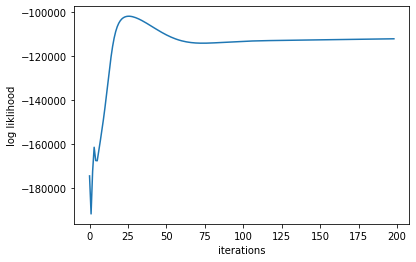

In [0]:

plt.plot(loglike[1:])
plt.xlabel("iterations")
plt.ylabel("log liklihood")